# Import and preprocess of italina Covi-19 dataset

In [118]:
import pandas as pd
import glob
import os

## Goal:

Create regional and national dataset whit information about covid-19 epidemic

## Dataset structure

Structure of dataset are same for national and regional scale, below the explanation of columns: <br>
<ul>
<li><b>total_cases: </b>cumulative number of infect<br></li>
<li><b>daily_cases: </b>daily new infect<br></li>
<li><b>actual_cases: </b>people actually infect<br></li>
<li><b>total_healed: </b>cumulative number of healed<br></li>
<li><b>daily_healed: </b>daily number of healed<br></li>
<li><b>total_dead: </b>cumulative number of dead<br></li>
<li><b>daily_dead: </b>daily number of dead<br></li>
<li><b>total_home_isolation: </b>cumulative number of people forced to home isolation<br></li>
<li><b>daily_home_isolation: </b>daily number of people forced to home isolation, variation between day before, can be negative<br></li>
<li><b>total_recovered_with_symptoms: </b>cumulative number of people recovered with symptoms<br></li>
<li><b>daily_recovered_with_symptoms: </b>daily number of people recovered with symptoms, variation between day before, can be negative<br></li>
<li><b>total_intensive_care: </b>cumulative number of people in intesive care<br></li>
<li><b>daily_intensive_care: </b>daily number of people in intesive care, variation between day before, can be negative<br></li>
<li><b>total_hospitalized: </b>cumulative number of hospitalized: simple recover + intensive care<br></li>
<li><b>daily_hospitalized: </b>daily number of hospitalized: simple recover + intensive care, variation between day before, can be negative<br></li>
<li><b>total_test: </b>cumulative number of test made<br></li>
<li><b>daily_test: </b>daily number of test made<br></li>
</ul>

In [120]:
#define colums of final dataset
dtregions_cols = ["total_cases","daily_cases","actual_cases","total_healed","daily_healed","total_dead","daily_dead",
                  "total_home_isolation","daily_home_isolation","total_recovered_with_symptoms","daily_recovered_with_symptoms",
                  "total_intensive_care","daily_intensive_care","total_hospitalized","daily_hospitalized","total_test","daily_test"]

#use rigth line, depens on your OS !!!
path = os.getcwd() + "/Data/Italia/COVID-19-master/dati-regioni/"
#path = os.getcwd() + "\\Data\\Italia\\COVID-19-master\\dati-regioni\\"

dailycsv = glob.glob(path + "/*.csv")

dailycsv.remove(os.getcwd() + "/Data/Italia/COVID-19-master/dati-regioni/" + "dpc-covid19-ita-regioni.csv")
dailycsv.remove(os.getcwd() + "/Data/Italia/COVID-19-master/dati-regioni/" + "dpc-covid19-ita-regioni-latest.csv")
#dailycsv.remove(os.getcwd() + "\\Data\\Italia\\COVID-19-master\\dati-regioni\\" + "dpc-covid19-ita-regioni.csv")
#dailycsv.remove(os.getcwd() + "\\Data\\Italia\\COVID-19-master\\dati-regioni\\" + "dpc-covid19-ita-regioni-latest.csv")

#define container for dataset
dtregions_ita_array = {} 



In [121]:
#read all daily CSV then put into dataset divided by region
for file in dailycsv:
    dtregions_ita = pd.read_csv(file, index_col = 0)
    for region in dtregions_ita["denominazione_regione"].values:
        try:
            dtregions_ita_array[region] = dtregions_ita_array[region].append(dtregions_ita.loc[dtregions_ita["denominazione_regione"] == region])
        except:
            dtregions_ita_array[region] = dtregions_ita.loc[dtregions_ita["denominazione_regione"] == region]
        dtregions_ita_array[region].drop(['stato', 'codice_regione', 'denominazione_regione', 'lat', 'long'], axis = 1, inplace = True)

In [122]:
#translate some name and sort dataset by date
for region in dtregions_ita_array:
    dtregions_ita_array[region].index.name = "date"
    dtregions_ita_array[region].sort_values(by=['date'], inplace = True)
    dtregions_ita_array[region].columns=['dead','healed', 'home_isolation',
       'new_actual_positive', 'hospitalized_with_symptoms', 'test',
       'intensive_care', 'total_actual_positive', 'total_cases',
       'total_hospitalized']  

In [123]:
#create sample datatset
dt_sample = dtregions_ita_array["Lombardia"].copy()[[]]
dt_sample = dt_sample.reindex(columns=dt_sample.columns.tolist() + dtregions_cols)

In [124]:
#define containmer for dataset
dtregions_array = {} 

#create one dataset forach region and start filling with avaible data
for region in dtregions_ita_array:
    dtregions_array[region] = dt_sample.copy()
    dtregions_array[region].total_cases = dtregions_ita_array[region].total_cases
    dtregions_array[region].total_healed = dtregions_ita_array[region].healed
    dtregions_array[region].total_dead = dtregions_ita_array[region].dead
    dtregions_array[region].total_recovered_with_symptoms = dtregions_ita_array[region].hospitalized_with_symptoms
    dtregions_array[region].total_intensive_care = dtregions_ita_array[region].intensive_care
    dtregions_array[region].total_home_isolation = dtregions_ita_array[region].home_isolation
    dtregions_array[region].total_hospitalized = dtregions_ita_array[region].total_hospitalized
    dtregions_array[region].total_test = dtregions_ita_array[region].test

In [125]:
#calculate the other data 
for region in dtregions_array:
    for i in range(len(dtregions_array[region].index)):
        if i == 0:
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("daily_cases")] = dtregions_array[region].iloc[i].total_cases
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("daily_healed")] = dtregions_array[region].iloc[i].total_healed
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("daily_dead")] = dtregions_array[region].iloc[i].total_dead
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("actual_cases")] = dtregions_array[region].iloc[i].total_cases - dtregions_array[region].iloc[i].total_dead- dtregions_array[region].iloc[i].total_healed
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("daily_home_isolation")] = dtregions_array[region].iloc[i].total_home_isolation
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("daily_recovered_with_symptoms")] = dtregions_array[region].iloc[i].total_recovered_with_symptoms
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("daily_intensive_care")] = dtregions_array[region].iloc[i].total_intensive_care
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("daily_hospitalized")] = dtregions_array[region].iloc[i].total_hospitalized
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("daily_test")] = dtregions_array[region].iloc[i].total_test
        else:
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("daily_cases")] = dtregions_array[region].iloc[i].total_cases - dtregions_array[region].iloc[i-1].total_cases
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("daily_dead")] = dtregions_array[region].iloc[i].total_dead - dtregions_array[region].iloc[i-1].total_dead
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("daily_healed")] = dtregions_array[region].iloc[i].total_healed - dtregions_array[region].iloc[i-1].total_healed
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("actual_cases")] = dtregions_array[region].iloc[i].total_cases - dtregions_array[region].iloc[i].total_dead- dtregions_array[region].iloc[i].total_healed
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("daily_home_isolation")] = dtregions_array[region].iloc[i].total_home_isolation - dtregions_array[region].iloc[i-1].total_home_isolation
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("daily_recovered_with_symptoms")] = dtregions_array[region].iloc[i].total_recovered_with_symptoms - dtregions_array[region].iloc[i-1].total_recovered_with_symptoms
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("daily_intensive_care")] = dtregions_array[region].iloc[i].total_intensive_care - dtregions_array[region].iloc[i-1].total_intensive_care
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("daily_hospitalized")] = dtregions_array[region].iloc[i].total_hospitalized - dtregions_array[region].iloc[i-1].total_hospitalized
            dtregions_array[region].iloc[i, dtregions_array[region].columns.get_loc("daily_test")] = dtregions_array[region].iloc[i].total_test - dtregions_array[region].iloc[i-1].total_test
    dtregions_array[region].loc[:,dtregions_cols] = dtregions_array[region].loc[:,dtregions_cols].astype(int)

Creiamo adesso un Dataframe raggruppando tutte le informazioni di ogni singola regione per singola data

In [126]:
dtregions_array["Lombardia"].head()

,total_cases,daily_cases,actual_cases,total_healed,daily_healed,total_dead,daily_dead,total_home_isolation,daily_home_isolation,total_recovered_with_symptoms,daily_recovered_with_symptoms,total_intensive_care,daily_intensive_care,total_hospitalized,daily_hospitalized,total_test,daily_test
date,,,,,,,,,,,,,,,,,
2020-02-24 18:00:00,172,172,166,0,0,6,6,71,71,76,76,19,19,95,95,1463,1463
2020-02-25 18:00:00,240,68,231,0,0,9,3,127,56,79,3,25,6,104,9,3700,2237
2020-02-26 18:00:00,258,18,249,0,0,9,0,145,18,79,0,25,0,104,0,3208,-492
2020-02-27 18:00:00,403,145,349,40,40,14,5,136,-9,172,93,41,16,213,109,3320,112
2020-02-28 18:00:00,531,128,474,40,0,17,3,192,56,235,63,47,6,282,69,4835,1515


In [127]:
dtregions_array["Lombardia"].tail()

,total_cases,daily_cases,actual_cases,total_healed,daily_healed,total_dead,daily_dead,total_home_isolation,daily_home_isolation,total_recovered_with_symptoms,daily_recovered_with_symptoms,total_intensive_care,daily_intensive_care,total_hospitalized,daily_hospitalized,total_test,daily_test
date,,,,,,,,,,,,,,,,,
2020-03-20 17:00:00,22264,2380,15420,4295,517,2549,381,6635,1090,7735,348,1050,44,8785,392,57174,4930
2020-03-21 17:00:00,25515,3251,17370,5050,755,3095,546,8019,1384,8258,523,1093,43,9351,566,66730,9556
2020-03-22 17:00:00,27206,1691,17885,5865,815,3456,361,7304,-715,9439,1181,1142,49,10581,1230,70598,3868
2020-03-23 17:00:00,28761,1555,18910,6075,210,3776,320,8461,1157,9266,-173,1183,41,10449,-132,73242,2644
2020-03-24 17:00:00,30703,1942,19868,6657,582,4178,402,8963,502,9711,445,1194,11,10905,456,76695,3453


In [128]:
#aggregate regional dataframe to create national data
dtitaly = dt_sample.copy()
dtitaly.fillna(0, inplace=True)

for i in range(len(dtregions_array["Lombardia"])):
    for region in dtregions_array:
        dtitaly.iloc[i] += dtregions_array[region].iloc[i]
        
dtitaly.loc[:,dtitaly.columns] = dtitaly.loc[:,dtitaly.columns].astype(int)

Converting dates from String to Datetime

In [129]:
import datetime as dt

index_list = dtitaly.index.tolist()

for i in range(len(index_list)):
    index_list[i] = dt.datetime.strptime(index_list[i], '%Y-%m-%d %H:%M:%S').date()

dtitaly.index = index_list
dtitaly.index.name = 'date'

dtitaly

,total_cases,daily_cases,actual_cases,total_healed,daily_healed,total_dead,daily_dead,total_home_isolation,daily_home_isolation,total_recovered_with_symptoms,daily_recovered_with_symptoms,total_intensive_care,daily_intensive_care,total_hospitalized,daily_hospitalized,total_test,daily_test
date,,,,,,,,,,,,,,,,,
2020-02-24,229,229,221,1,1,7,7,94,94,101,101,26,26,127,127,4324,4324
2020-02-25,322,93,311,1,0,10,3,162,68,114,13,35,9,150,23,8623,4299
2020-02-26,400,78,385,3,2,12,2,221,59,128,14,36,1,164,14,9587,964
2020-02-27,650,250,588,45,42,17,5,284,63,248,120,56,20,304,140,12014,2427
2020-02-28,888,238,821,46,1,21,4,412,128,345,97,64,8,409,105,15695,3681
2020-02-29,1128,240,1049,50,4,29,8,543,131,401,56,105,41,506,97,18661,2966
2020-03-01,1694,566,1577,83,33,34,5,798,255,639,238,140,35,779,273,21127,2466
2020-03-02,2036,342,1835,149,66,52,18,927,129,742,103,166,26,908,129,23345,2218
2020-03-03,2502,466,2263,160,11,79,27,1000,73,1034,292,229,63,1263,355,25856,2511


## Plot data

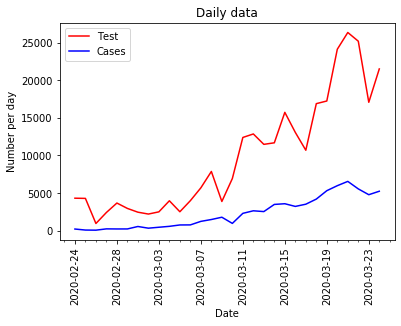

In [130]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import matplotlib.ticker as tkr

plt.title('Daily data')
plt.plot(dtitaly.index, dtitaly.daily_test, 'r')
plt.plot(dtitaly.index, dtitaly.daily_cases, 'b')


plt.setp(plt.gca().xaxis.get_majorticklabels(),rotation=90)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.gca().xaxis.set_minor_locator(mdates.DayLocator())

plt.xlabel('Date')
plt.ylabel('Number per day')
plt.legend(["Test", "Cases"])
plt.show()

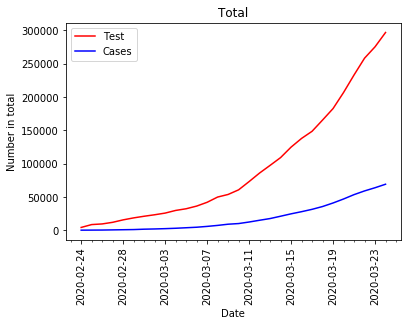

In [131]:
plt.title('Total')

plt.plot(dtitaly.index, dtitaly.total_test, 'r')
plt.plot(dtitaly.index, dtitaly.total_cases, 'b')

plt.setp(plt.gca().xaxis.get_majorticklabels(),rotation=90)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.gca().xaxis.set_minor_locator(mdates.DayLocator())

plt.xlabel('Date')
plt.ylabel('Number in total')
plt.legend(["Test", "Cases"])
plt.show()

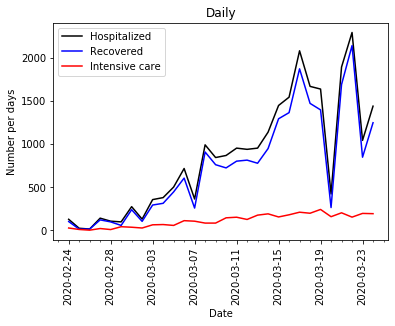

In [132]:
import numpy as np
plt.title('Daily')

plt.plot(dtitaly.index, dtitaly.daily_hospitalized, 'k')
plt.plot(dtitaly.index, dtitaly.daily_recovered_with_symptoms, 'b')
plt.plot(dtitaly.index, dtitaly.daily_intensive_care, 'r')

plt.setp(plt.gca().xaxis.get_majorticklabels(),rotation=90)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.gca().xaxis.set_minor_locator(mdates.DayLocator())

plt.xlabel('Date')
plt.ylabel('Number per days')
plt.legend(["Hospitalized", "Recovered", "Intensive care"])
plt.show()

Prima dell'inizio della crisi, secondo i dati del Prontuario statistico nazionale, in Italia c'erano 5090 posti letto. 

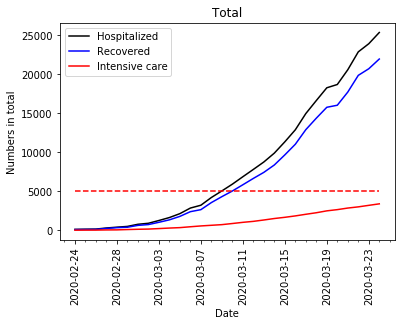

In [133]:
plt.title('Total')

plt.plot(dtitaly.index, dtitaly.total_hospitalized, 'k')
plt.plot(dtitaly.index, dtitaly.total_recovered_with_symptoms, 'b')
plt.plot(dtitaly.index, dtitaly.total_intensive_care, 'r')

horiz_line_data = np.array([5090 for i in range(len(dtitaly.index))])
plt.plot(dtitaly.index, horiz_line_data, 'r--')

plt.setp(plt.gca().xaxis.get_majorticklabels(),rotation=90)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.gca().xaxis.set_minor_locator(mdates.DayLocator())

plt.xlabel('Date')
plt.ylabel('Numbers in total')
plt.legend(["Hospitalized", "Recovered", "Intensive care"])
plt.show()

In [134]:
#save data as CSV 

path = os.getcwd() + "\\parsed_data\\italy\\"
for region in dtregions_array:
    dtregions_array[region].to_csv (path + region.lower() + ".csv", index = True, header=True)

dtitaly.to_csv (path + "italy.csv", index = True, header=True)
